In [2]:
# non markov
#imports
import numpy as np
import numpy.random as rd
import numpy.linalg as linalg
import math
from scipy.optimize import linprog
import matplotlib.pyplot as plt
from hmmlearn import hmm
import cvxopt

In [3]:
def sample(prob): # BS can be done
    r = rd.random();i = 0
    while r > prob[i]:
        r-=prob[i]
        i+=1
    return i

def bernoulli(prob):
    if rd.random() > prob:
        return 1.0
    return 0.0

def row_normalize(arr):
    arr = np.array(arr,float)
    for i in range(np.shape(arr)[0]):
        arr[i] = arr[i]/np.sum(arr[i])
    return arr

def dot(x,y):
    return np.sum(np.multiply(x,y))

def steady_state_prob(matrix):
    """
    This function calculates relative throughput from a probability matrix
    :param matrix: the probability matrix
    :return: A list of relative throughput values
    """
    a_list = []
    b_list = []
    for v in matrix:
        a_list.append(1)
        b_list.append(0)
    b_list.append(1)
    A = np.append(np.transpose(matrix) - np.identity(len(matrix)), [a_list], axis=0)
    b = np.transpose(np.array(b_list))
    return np.linalg.solve(np.transpose(A).dot(A), np.transpose(A).dot(b))

In [36]:
# example 2
en = 6
ch = 8
P = np.array([.3,.1,.2,.4,.3,.1,.3,.3])/2
E = np.array([[.4,.6,.4,.3,.1,.35,.3,.4],[.3,.4,.4,.3,.3,.35,.25,.4],[.3,.2,.1,.4,.3,.4,.4,.3],[.4,.3,.3,.5,.6,.4,.55,.35],[.2,.4,.1,.3,.4,.4,.3,.1],[.4,.6,.4,.3,.6,.4,.3,.1]])/2
R = np.array([4.,3.5,4.,8.,2.,3.])
tol = .2
print(P)
print(E)
print(R)
print(tol)
# finding safe x0
ub = E.transpose();tol_arr = [tol]*ch
ltemp = linprog(c=np.zeros(en),A_ub = ub,b_ub=tol_arr,A_eq = np.ones((1,en)),b_eq = [1.0],method='revised simplex',options={'tol': 1.0e-3})
x0 = np.transpose(row_normalize([ltemp.x+(0.0)])) # noise to safe to avoid singular matrices, 1.0e-2 is working
norm_x0 = linalg.norm(x0)
e0 = x0/norm_x0 # safe vector
e0_trans = e0.transpose()
en0 = sample(x0.transpose()[0])
b0 = bernoulli(E[en0][sample(P)])
yt = (E[en0]*(1-b0))+((1-E[en0])*b0)
yt = row_normalize([np.exp(yt)]).transpose()
c0 = dot(x0,np.matmul(E,yt)) # safe cost
print(x0.flatten(),c0)
# parameters
reg = 0.1 # lambda > 0, regualarization param
conf = 0.1 # delta >= 0, <= 1, confidence prob -> with 1-del prob tolerance holds
alfa_c = 0.001 # >= 1, ellipse radii, best : 0.001
Sa = 1.;La = 1.;Ra = 1. # assumption parameters
R_sum = np.sum(R)
Rn_trans = R/R_sum
Rn = np.transpose([Rn_trans])
# x = [np.transpose(row_normalize([np.ones(en)]))]
x = [x0]
r = [dot(x[-1],Rn)];c = [c0]
b = []; enc = [];chnl = []
avg_rate = []
# algo
iop = np.identity(en) - (np.matmul(x0,x0.transpose())/pow(norm_x0,2.0))
sigopt = reg*iop; uopt = 0.0
for t in range(1,10000):
    enc.append(sample(x[-1].transpose()[0]))
    chnl.append(sample(P))
    b.append(bernoulli(E[enc[-1]][chnl[-1]]))
    yt = (E[enc[-1]]*(1-b[-1]))+((1-E[enc[-1]])*b[-1])
    yt = row_normalize([np.exp(yt)]).transpose()
    r.append(dot(x[-1],Rn))
    c.append(1.0 - b[-1])  # c.append(dot(x[-1],np.matmul(E,yt)))
    copt = c[-1] - (dot(x[-1],e0)/norm_x0)*c[0]
    xopt = x[-1] - (dot(x[-1],e0)*e0)
    sigopt += np.matmul(xopt,xopt.transpose())
    uopt += (copt*xopt)
    muopt = np.matmul(linalg.pinv(sigopt),uopt) # (inverse is blowing up, singular matrices) so did pseudo(SVD)
    ub = ((c[0]/norm_x0)*e0_trans)+muopt.transpose()+(dot(e0,muopt)*e0_trans)
    betat = Ra*math.sqrt(en*math.log10((1+(t-1)*La*La/reg)/conf))+math.sqrt(reg)*Sa # used log10
    val = alfa_c*betat*linalg.norm(xopt)
    try:
        ltemp = linprog(c = -1*Rn_trans, A_ub = ub, b_ub = [tol-val],A_eq = np.ones((1,en)),b_eq = [1.0],method='revised simplex',options={'tol': 1.0e-2})
    except:
        print(t,'skipped')
        continue
    x.append(np.transpose([ltemp.x]))
    avg_rate.append(dot(x[-1],Rn)*R_sum)
    print(t,avg_rate[-1],ltemp.success)
# print(copt)
# print(xopt)
# print(sigopt)
# print(uopt)
# print(muopt)
# print(ub,betat)
error_plot_oplb = 1.0 - np.copy(b)
for i in range(1,len(error_plot_oplb)):
    error_plot_oplb[i] += (error_plot_oplb[i-1]*(i-1))
    error_plot_oplb[i] =error_plot_oplb[i]/i
rate_plot_oplb = np.copy(avg_rate)
for i in range(1,len(rate_plot_oplb)):
    rate_plot_oplb[i] += (rate_plot_oplb[i-1]*(i-1))
    rate_plot_oplb[i] =rate_plot_oplb[i]/i

[0.15 0.05 0.1  0.2  0.15 0.05 0.15 0.15]
[[0.2   0.3   0.2   0.15  0.05  0.175 0.15  0.2  ]
 [0.15  0.2   0.2   0.15  0.15  0.175 0.125 0.2  ]
 [0.15  0.1   0.05  0.2   0.15  0.2   0.2   0.15 ]
 [0.2   0.15  0.15  0.25  0.3   0.2   0.275 0.175]
 [0.1   0.2   0.05  0.15  0.2   0.2   0.15  0.05 ]
 [0.2   0.3   0.2   0.15  0.3   0.2   0.15  0.05 ]]
[4.  3.5 4.  8.  2.  3. ]
0.2
[0.5 0.  0.5 0.  0.  0. ] 0.16350375744491838
1 7.999999999999999 True
2 7.999999999999999 True
3 7.999999999999999 True
4 7.999999999999999 True
5 7.111115006064886 True
6 5.841199155827534 True
7 6.878619413193594 True
8 7.150113994477943 True
9 7.331730859715986 True
10 7.480303416301169 True
11 7.616473375296672 True
12 7.752000628754241 True
13 7.896885845911969 True
14 7.999999999999999 True
15 7.999999999999999 True
16 7.999999999999999 True
17 7.999999999999999 True
18 7.999999999999999 True
19 7.999999999999999 True
20 7.999999999999999 True
21 7.999999999999999 True
22 7.838673970134269 True
23 7.9087634

In [39]:
# example 2
en = 6
ch = 8
P = np.array([.3,.1,.2,.4,.3,.1,.3,.3])/2
E = np.array([[.4,.6,.4,.3,.1,.35,.3,.4],[.3,.4,.4,.3,.3,.35,.25,.4],[.3,.2,.1,.4,.3,.4,.4,.3],[.4,.3,.3,.5,.6,.4,.55,.35],[.2,.4,.1,.3,.4,.4,.3,.1],[.4,.6,.4,.3,.6,.4,.3,.1]])/2
R = np.array([4.,3.5,4.,8.,2.,3.])
tol = .2
print(P)
print(E)
print(R)
print(tol)
# make sure arm 1 is safe
b = [max(i) for i in E]
if min(b) > tol:
    print('No Specific arm is safe')
else:
    m = np.argmin(b)
    E[[m,0]] = E[[0,m]]
    R[[m,0]] = R[[0,m]]
print(m)
# print(E)
# print(R)
# parameters
alfa_c = 0.001 # >= 1, ellipse radii, best : 0.001
conf = 0.1 # delta >= 0, <= 1, confidence prob -> with 1-del prob tolerance holds
R_sum = np.sum(R)
Rn_trans = R/R_sum
Rn = np.transpose([Rn_trans])
# x = [np.transpose(row_normalize([np.ones(en)]))]
pi = [np.transpose([[1.0]+[0.0 for i in range(en-1)]])]
r = [dot(pi[-1],Rn)];c = [bernoulli(max(E[m]))]
b = []; enc = [];chnl = []
avg_rate = []
# print(pi,r,c,R,Rn)
ta = np.ones(en)
ra = np.zeros(en)+np.mean(Rn) # look for good initialisations - like sampling each and populating these!!
ca = np.array([np.min(i) for i in E])
uca = np.zeros(en)
# algo
for t in range(1,10000):
    enc.append(sample(pi[-1].transpose()[0]))
    chnl.append(sample(P))
    b.append(bernoulli(E[enc[-1]][chnl[-1]]))
    r.append(Rn[enc[-1]])
    c.append(1.0 - b[-1])
    ta[enc[-1]]+=1.0
    ca[enc[-1]] = ((ca[enc[-1]]*(ta[enc[-1]]-1))+c[-1])/ta[enc[-1]]
    for i in range(en):
        uca[i] = ca[i] + alfa_c*np.sqrt(2.0*np.log(1.0/conf)/ta[i])
    try:
        ltemp = linprog(c = -1*Rn_trans, A_ub = [uca], b_ub = [tol],A_eq = np.ones((1,en)),b_eq = [1.0],method='revised simplex',options={'tol': 1.0e-2})
    except:
        print(t,'skipped')
        continue
    pi.append(np.transpose([ltemp.x]))
    avg_rate.append(dot(pi[-1],Rn)*R_sum)
    print(t,avg_rate[-1],ltemp.success)
error_plot_opb = 1.0 - np.copy(b)
for i in range(1,len(error_plot_opb)):
    error_plot_opb[i] += (error_plot_opb[i-1]*(i-1))
    error_plot_opb[i] =error_plot_opb[i]/i
rate_plot_opb = np.copy(avg_rate)
for i in range(1,len(rate_plot_opb)):
    rate_plot_opb[i] += (rate_plot_opb[i-1]*(i-1))
    rate_plot_opb[i] =rate_plot_opb[i]/i

[0.15 0.05 0.1  0.2  0.15 0.05 0.15 0.15]
[[0.2   0.3   0.2   0.15  0.05  0.175 0.15  0.2  ]
 [0.15  0.2   0.2   0.15  0.15  0.175 0.125 0.2  ]
 [0.15  0.1   0.05  0.2   0.15  0.2   0.2   0.15 ]
 [0.2   0.15  0.15  0.25  0.3   0.2   0.275 0.175]
 [0.1   0.2   0.05  0.15  0.2   0.2   0.15  0.05 ]
 [0.2   0.3   0.2   0.15  0.3   0.2   0.15  0.05 ]]
[4.  3.5 4.  8.  2.  3. ]
0.2
1
1 7.999999999999999 True
2 7.999999999999999 True
3 7.999999999999999 True
4 6.5014744229832395 True
5 6.648027396871018 True
6 6.69104292722004 True
7 5.763394915497142 True
8 5.561232011310601 True
9 5.715770900171405 True
10 5.763394915497142 True
11 6.134103050394392 True
12 6.157492635359529 True
13 5.7054964807992885 True
14 5.082036166951134 True
15 5.35155132081689 True
16 5.510575763791227 True
17 5.583313926508926 True
18 5.256788161430014 True
19 5.468267883309597 True
20 5.509605664169524 True
21 5.725199465465298 True
22 5.94367597797967 True
23 6.165094518948902 True
24 6.389515910727328 True
25 6.

In [42]:
# example 2
en = 6
ch = 8
P = np.array([.3,.1,.2,.4,.3,.1,.3,.3])/2
E = np.array([[.4,.6,.4,.3,.1,.35,.3,.4],[.3,.4,.4,.3,.3,.35,.25,.4],[.3,.2,.1,.4,.3,.4,.4,.3],[.4,.3,.3,.5,.6,.4,.55,.35],[.2,.4,.1,.3,.4,.4,.3,.1],[.4,.6,.4,.3,.6,.4,.3,.1]])/2
R = np.array([4.,3.5,4.,8.,2.,3.])
tol = .2
print(P)
print(E)
print(R)
print(tol)
# finding safe x0
ub = E.transpose();tol_arr = [tol]*ch
ltemp = linprog(c=np.zeros(en),A_ub = ub,b_ub=tol_arr,A_eq = np.ones((1,en)),b_eq = [1.0],method='revised simplex',options={'tol': 1.0e-3})
x0 = np.transpose(row_normalize([ltemp.x+(0.05)])) # noise to safe to avoid singular matrices, 1.0e-2 is working
norm_x0 = linalg.norm(x0)
e0 = x0/norm_x0 # safe vector
e0_trans = e0.transpose()
en0 = sample(x0.transpose()[0])
b0 = bernoulli(E[en0][sample(P)])
# yt = (E[en0]*(1-b0))+((1-E[en0])*b0)
# yt = row_normalize([np.exp(yt)]).transpose()
# c0 = dot(x0,np.matmul(E,yt)) # safe cost
print(x0.flatten(),np.max(np.matmul(x0.transpose(),E)),dot(x0.transpose(),R))
# parameters
reg = 0.1 # lambda > 0, regualarization param
conf = 0.1 # delta >= 0, <= 1, confidence prob -> with 1-del prob tolerance holds
alfa_c = 1.0 # >= 1, ellipse radii
Sa = 1.;La = 1.;Ra = 1. # assumption parameters
# x = [np.transpose(row_normalize([np.ones(en)]))]
x = [x0]
r = [dot(x[-1].transpose(),R)];c = [c0]
b = []; enc = [];chnl = []
rate = []
def qclp_solver(A,C,x0,R,en,tol):
    A = cvxopt.matrix(A)
    C = cvxopt.matrix(C)
    x0 = cvxopt.matrix(x0)
    R = cvxopt.matrix(R)
    def F(x = None, z = None):
        if x is None:  return (1, x0)
        if max(x) > 1.0 or min(x) < 0.0: return (None,None)
        f = (A*x) +  (x.trans()*C*x) - cvxopt.matrix([tol])
        df = A + (2.0*C*x).trans()
        if z is None: return (f,df)
        h = 2*z[0]*C
        return (f,df,h)
    sol = cvxopt.solvers.cpl(-1.0*R, F, None, None, None, cvxopt.matrix([1.0]*en).trans(), cvxopt.matrix([1.0]),kktsolver='ldl', options={'show_progress':False,'kktreg':1e-5})['x']
    return np.array(sol), ((A*sol)+(sol.trans()*C*sol))[0]
# 'kktreg':1e-9, kktsolver='ldl','maxiters':30
# algo
iop = np.identity(en) - (np.matmul(x0,x0.transpose())/pow(norm_x0,2.0))
sigopt = reg*iop; uopt = 0.0
for t in range(1,10000):
    enc.append(sample(x[-1].transpose()[0]))
    chnl.append(sample(P))
    b.append(bernoulli(E[enc[-1]][chnl[-1]]))
    # yt = (E[enc[-1]]*(1-b[-1]))+((1-E[enc[-1]])*b[-1])
    # yt = row_normalize([np.exp(yt)]).transpose()
    r.append(dot(x[-1],R))
    c.append(1.0 - b[-1])  # c.append(dot(x[-1],np.matmul(E,yt)))
    copt = c[-1] - (dot(x[-1],e0)/norm_x0)*c[0]
    xopt = x[-1] - (dot(x[-1],e0)*e0)
    sigopt += np.matmul(xopt,xopt.transpose())
    uopt += (copt*xopt)
    muopt = np.matmul(linalg.pinv(sigopt),uopt) # (inverse is blowing up, singular matrices) so did pseudo(SVD)
    A = (((c[0]/norm_x0)*e0_trans)+muopt.transpose()+(dot(e0,muopt)*e0_trans))
    betat = Ra*math.sqrt(en*math.log10((1+(t-1)*La*La/reg)/conf))+math.sqrt(reg)*Sa # used log10
    d = -2*alfa_c*betat
    l = alfa_c*betat*(1+pow(dot(e0,e0),2.0))
    C = ((l*np.identity(en)) + (d*np.matmul(e0,e0_trans)))
    sol = qclp_solver(A,C,x0,R,en,tol)
    x.append(sol[0])
    rate.append(dot(x[-1].transpose(),R))
    print(t,rate[-1],sol[1])
# print(copt)
# print(xopt)
# print(sigopt)
# print(uopt)
# print(muopt)
# print(A,betat)
error_plot_oplb_cvx = 1.0 - np.copy(b)
for i in range(1,len(error_plot_oplb_cvx)):
    error_plot_oplb_cvx[i] += (error_plot_oplb_cvx[i-1]*(i-1))
    error_plot_oplb_cvx[i] =error_plot_oplb_cvx[i]/i
rate_plot_oplb_cvx = np.copy(rate)
for i in range(1,len(rate_plot_oplb_cvx)):
    rate_plot_oplb_cvx[i] += (rate_plot_oplb_cvx[i-1]*(i-1))
    rate_plot_oplb_cvx[i] =rate_plot_oplb_cvx[i]/i

[0.15 0.05 0.1  0.2  0.15 0.05 0.15 0.15]
[[0.2   0.3   0.2   0.15  0.05  0.175 0.15  0.2  ]
 [0.15  0.2   0.2   0.15  0.15  0.175 0.125 0.2  ]
 [0.15  0.1   0.05  0.2   0.15  0.2   0.2   0.15 ]
 [0.2   0.15  0.15  0.25  0.3   0.2   0.275 0.175]
 [0.1   0.2   0.05  0.15  0.2   0.2   0.15  0.05 ]
 [0.2   0.3   0.2   0.15  0.3   0.2   0.15  0.05 ]]
[4.  3.5 4.  8.  2.  3. ]
0.2
[0.42307692 0.03846154 0.42307692 0.03846154 0.03846154 0.03846154] 0.20192307692307693 4.019230769230769
1 4.482087665112699 0.21502936672064513
2 4.473831042086671 0.2196393849551942
3 4.21651804341881 0.20000001164825193
4 4.172873177581373 0.20000000306635787
5 4.178265674113701 0.2000000003882805
6 4.184249415751446 0.20000000051064823
7 4.190838995801229 0.20000001330144637
8 4.198073132109002 0.2000000066381441
9 4.206003278471713 0.20000001340846402
10 4.214687535366087 0.20000000016278963
11 4.177202284335296 0.20000000326504955
12 4.182850838014483 0.20000000417170619
13 4.188962250894898 0.2000000005463

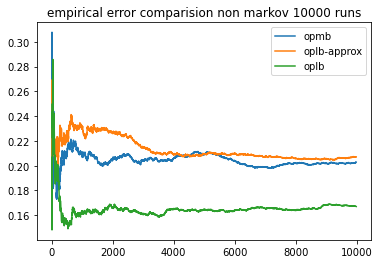

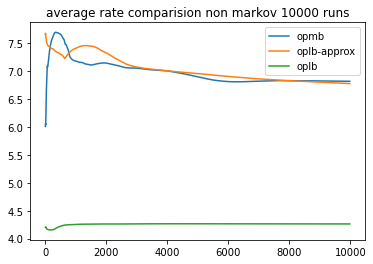

In [43]:
stat = 20
plt.plot(error_plot_opb[stat:])
plt.plot(error_plot_oplb[stat:])
plt.plot(error_plot_oplb_cvx[stat:])
plt.title('empirical error comparision non markov 10000 runs')
plt.legend(['opmb','oplb-approx','oplb'])
plt.show()
stat = 20
plt.plot(rate_plot_opb[stat:])
plt.plot(rate_plot_oplb[stat:])
plt.plot(rate_plot_oplb_cvx[stat:])
plt.title('average rate comparision non markov 10000 runs')
plt.legend(['opmb','oplb-approx','oplb'])
plt.show()

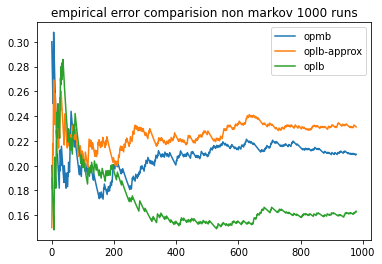

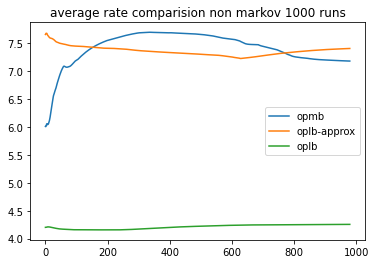

In [44]:
stat = 20
plt.plot(error_plot_opb[stat:1000])
plt.plot(error_plot_oplb[stat:1000])
plt.plot(error_plot_oplb_cvx[stat:1000])
plt.title('empirical error comparision non markov 1000 runs')
plt.legend(['opmb','oplb-approx','oplb'])
plt.show()
stat = 20
plt.plot(rate_plot_opb[stat:1000])
plt.plot(rate_plot_oplb[stat:1000])
plt.plot(rate_plot_oplb_cvx[stat:1000])
plt.title('average rate comparision non markov 1000 runs')
plt.legend(['opmb','oplb-approx','oplb'])
plt.show()

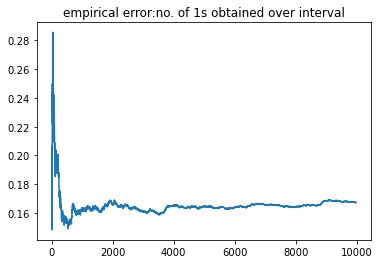

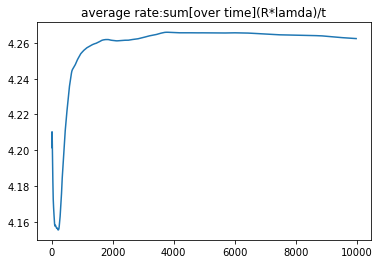

0.16703340668133662 4.262408993544739


In [45]:
stat = 20
error_plot = 1.0 - np.copy(b)
for i in range(1,len(error_plot)):
    error_plot[i] += (error_plot[i-1]*(i-1))
    error_plot[i] =error_plot[i]/i
plt.plot(error_plot[stat:])
plt.title('empirical error:no. of 1s obtained over interval')
plt.show()
rate_plot = np.copy(rate)
for i in range(1,len(rate_plot)):
    rate_plot[i] += (rate_plot[i-1]*(i-1))
    rate_plot[i] =rate_plot[i]/i
plt.plot(rate_plot[stat:])
plt.title('average rate:sum[over time](R*lamda)/t')
plt.show()
print(error_plot[-1],rate_plot[-1])

In [1]:
# Markov plots

In [28]:
en = 5
ch = 4
P = np.array([[.35,.15,.05,.45],[.3,.3,.2,.2],[.3,.4,.1,.2],[.2,.15,.25,.4]])
E = np.array([[.4,.6,.4,.3],[.3,.4,.4,.3],[.3,.2,.1,.4],[.1,.35,.3,.4],[.2,.4,.1,.3]])
R = np.array([7.,5.5,4.,6.,5.])
tol = .35
print(P)
print(E)
print(R)
print(tol)
lamda = [np.ones(en)/en]
p = []
# p.append(row_normalize(np.random.rand(ch,ch)))
p.append(row_normalize(np.ones((ch,ch))))
pckts = 1
chnl = []; b = [] ; enc = []
emp_rate = [0]; emp_err_a3 = [0]
chnl.append(rd.randint(0,ch-1))
enc.append(rd.randint(0,en-1))
b.append(np.zeros(pckts))
step = 50
t = 0
lr = 0.01
beta = 5
T = 50000
sprob = steady_state_prob(p[-1])
temp = np.copy(p[-1])
while t <= T:
    enc.append(sample(lamda[-1]))
    chnl.append(sample(P[chnl[-1]]))
    b.append(np.zeros(pckts))
    for i in range(pckts):
        b[t+1][i] = bernoulli(E[enc[-1]][chnl[-1]])
    tprob = np.zeros(ch)
    ones = np.sum(b[-1])
    for j in range(ch):
        tprob[j] = math.exp(beta*(((pckts-ones)*E[enc[-1]][j])+((ones)*(1-E[enc[-1]][j]))))
    tprob = row_normalize([tprob])[0]
    for i in range(ch):
        for j in range(ch):
            temp[i,j] = temp[i,j] + lr*((sprob[i]*tprob[j]) - temp[i,j])
    temp = row_normalize(temp)

    if t%step == 0:
        p.append(temp)
        sprob = steady_state_prob(p[-1])
        ub = np.sum(E*sprob,axis=1)
        ltemp = linprog(c = -1*R, A_ub = [ub], b_ub = [tol],A_eq = np.ones((1,en)),b_eq = [1.0],method='revised simplex',options={'tol': 1e-2})
        sprob = np.exp(beta*sprob)
        sprob = row_normalize([sprob])[0]
        temp = np.copy(p[-1])
        lamda.append(ltemp.x)
        emp_err.append(np.dot(ltemp.x,ub))
        emp_rate.append(np.dot(ltemp.x,R))
        print(t,emp_rate[-1],ltemp.success)
    t+=1
# new proper plots
error_plot_a3 = float(pckts) - np.sum(b,axis=1)
# error_plot_a3 = [np.mean(error_plot_a3[i*step:(i+1)*step]) for i in range(int((t+1)/step))]
for i in range(1,len(error_plot_a3)):
    error_plot_a3[i] += (error_plot_a3[i-1]*(i-1))
    error_plot_a3[i] =error_plot_a3[i]/i
# rate_plot_a3 = np.copy(emp_rate)
rate_plot_a3 = []
for i in emp_rate:
    rate_plot_a3.extend([i]*step)
for i in range(1,len(rate_plot_a3)):
    rate_plot_a3[i] += (rate_plot_a3[i-1]*(i-1))
    rate_plot_a3[i] =rate_plot_a3[i]/i
err_a3 = []; s = np.shape(P)[0]*np.shape(P)[1]
for i in range(len(p)):
    err_a3.append(np.sqrt(np.sum(np.square(steady_state_prob(P)-steady_state_prob(p[i])))))
    err_a3[i] += (err_a3[i-1]*(i))
    err_a3[i] = err_a3[i]/(i+1)

[[0.35 0.15 0.05 0.45]
 [0.3  0.3  0.2  0.2 ]
 [0.3  0.4  0.1  0.2 ]
 [0.2  0.15 0.25 0.4 ]]
[[0.4  0.6  0.4  0.3 ]
 [0.3  0.4  0.4  0.3 ]
 [0.3  0.2  0.1  0.4 ]
 [0.1  0.35 0.3  0.4 ]
 [0.2  0.4  0.1  0.3 ]]
[7.  5.5 4.  6.  5. ]
0.35
0 6.454932605822339 True
50 6.468133717007845 True
100 6.4789629156968305 True
150 6.486796981612864 True
200 6.494095592632459 True
250 6.49566063961802 True
300 6.4946200405329595 True
350 6.497074456170277 True
400 6.499835389251707 True
450 6.503010199673781 True
500 6.50616427419525 True
550 6.506808621602379 True
600 6.506622266476894 True
650 6.509446802913779 True
700 6.509555004443759 True
750 6.510578046829421 True
800 6.518491869385956 True
850 6.519682831008691 True
900 6.522805243035034 True
950 6.519703496580384 True
1000 6.520020152935722 True
1050 6.519883288370025 True
1100 6.520605201651371 True
1150 6.522233258545482 True
1200 6.5211543118575115 True
1250 6.5255064464719705 True
1300 6.521544682442253 True
1350 6.531290218681067 True
1

In [29]:
en = 5
ch = 4
P = np.array([[.35,.15,.05,.45],[.3,.3,.2,.2],[.3,.4,.1,.2],[.2,.15,.25,.4]])
E = np.array([[.4,.6,.4,.3],[.3,.4,.4,.3],[.3,.2,.1,.4],[.1,.35,.3,.4],[.2,.4,.1,.3]])
R = np.array([7.,5.5,4.,6.,5.])
tol = .35
print(P)
print(E)
print(R)
print(tol)
rate = R
lr = 0.001
lr_max = 0.01
eps = .5
eps_min = 0.01
lamda = [np.ones(en)/en]
p = []
# p.append(row_normalize(np.random.rand(ch,ch)))
p.append(row_normalize(np.ones((ch,ch))))
chnl = []; b = [] ; enc = []
emp_rate = [0]; emp_err_hmm = [0]
chnl.append(rd.randint(0,ch-1))
enc.append(rd.randint(0,en-1))
b.append(0)
step = 50
t = 0
T = 50000
sprob = steady_state_prob(p[-1])
r = rd.rand()
while t < T:
    if r < max(eps_min,eps/float(t+1)): # put as running eps
        enc.append(rd.randint(0,en))
    else:
        enc.append(sample(lamda[-1]))
    chnl.append(sample(P[chnl[-1]]))
    b.append(int(bernoulli(E[enc[-1]][chnl[-1]])))
    if (t+1)%step == 0:
        model = hmm.MultinomialHMM(n_components=ch, params='t', init_params='',n_iter=100, tol=1.0e-2)
        model.startprob_ = sprob
        if r < max(eps_min,eps/float(t+1)):
            step_emiss = np.sum(E,axis=0)/3
        else:
            step_emiss = np.sum(np.transpose([lamda[-1]])*E,axis=0)
        model.emissionprob_ = [[step_emiss[i],1-step_emiss[i]] for i in range(ch)]
        model.transmat_ = np.copy(p[-1])
        model.fit([b[-1*step:]])
        temp = np.copy(p[-1])
        lr = min(lr_max,float(step)/(10.0*float(t+1))) # adaptive learning rate
        temp = temp + lr*(model.transmat_-temp) # progressive update
        temp = row_normalize(temp)
        p.append(temp)
        sprob = steady_state_prob(p[-1])
        ub = np.sum(E*sprob,axis=1)
        ltemp = linprog(c = -1*rate, A_ub = [ub], b_ub = [tol],A_eq = np.ones((1,en)),b_eq = [1.0],method='revised simplex',options={'tol': 1.0e-2})
        lamda.append(ltemp.x)
        r = rd.rand()
        emp_err.append(np.dot(ltemp.x,ub))
        emp_rate.append(np.dot(ltemp.x,rate))
        print(t,emp_rate[-1],ltemp.success,lr,)
    t+=1
error_plot_hmm = 1.0 - np.copy(b)
# error_plot_hmm = [np.mean(error_plot_hmm[i*step:(i+1)*step]) for i in range(int((t+1)/step))]
for i in range(1,len(error_plot_hmm)):
    error_plot_hmm[i] += (error_plot_hmm[i-1]*(i-1))
    error_plot_hmm[i] =error_plot_hmm[i]/i
# rate_plot_hmm = np.copy(emp_rate)
rate_plot_hmm = []
for i in emp_rate:
    rate_plot_hmm.extend([i]*step)
for i in range(1,len(rate_plot_hmm)):
    rate_plot_hmm[i] += (rate_plot_hmm[i-1]*(i-1))
    rate_plot_hmm[i] = rate_plot_hmm[i]/i
err_hmm = []; s = np.shape(P)[0]*np.shape(P)[1]
for i in range(len(p)):
    err_hmm.append(np.sqrt(np.sum(np.square(steady_state_prob(P)-steady_state_prob(p[i])))))
    err_hmm[i] += (err_hmm[i-1]*(i))
    err_hmm[i] = err_hmm[i]/(i+1)

[[0.35 0.15 0.05 0.45]
 [0.3  0.3  0.2  0.2 ]
 [0.3  0.4  0.1  0.2 ]
 [0.2  0.15 0.25 0.4 ]]
[[0.4  0.6  0.4  0.3 ]
 [0.3  0.4  0.4  0.3 ]
 [0.3  0.2  0.1  0.4 ]
 [0.1  0.35 0.3  0.4 ]
 [0.2  0.4  0.1  0.3 ]]
[7.  5.5 4.  6.  5. ]
0.35
49 6.448282308870803 True 0.01
99 6.450301723259102 True 0.01
149 6.450231423366031 True 0.01
199 6.451193034871702 True 0.01
249 6.454742582054958 True 0.01
299 6.453365244572554 True 0.01
349 6.453295345076414 True 0.01
399 6.448660046130767 True 0.01
449 6.451828831748067 True 0.01
499 6.450449581734752 True 0.01
549 6.453449307867841 True 0.00909090909090909
599 6.449993239562787 True 0.008333333333333333
649 6.4489063505986755 True 0.007692307692307693
699 6.450251594464092 True 0.007142857142857143
749 6.450684038281583 True 0.006666666666666667
799 6.4527421219596945 True 0.00625
849 6.4539115987023425 True 0.0058823529411764705
899 6.453872700298636 True 0.005555555555555556
949 6.451320395603027 True 0.005263157894736842
999 6.4500252562136 True

In [30]:
en = 5
ch = 4
P = np.array([[.35,.15,.05,.45],[.3,.3,.2,.2],[.3,.4,.1,.2],[.2,.15,.25,.4]])
E = np.array([[.4,.6,.4,.3],[.3,.4,.4,.3],[.3,.2,.1,.4],[.1,.35,.3,.4],[.2,.4,.1,.3]])
R = np.array([7.,5.5,4.,6.,5.])
tol = .35
print(P)
print(E)
print(R)
print(tol)
# finding safe x0
ub = E.transpose();tol_arr = [tol]*ch
ltemp = linprog(c=np.zeros(en),A_ub = ub,b_ub=tol_arr,A_eq = np.ones((1,en)),b_eq = [1.0],method='revised simplex',options={'tol': 1.0e-3})
x0 = np.transpose(row_normalize([ltemp.x+(0.0)])) # noise to safe to avoid singular matrices, 1.0e-2 is working
norm_x0 = linalg.norm(x0)
e0 = x0/norm_x0 # safe vector
e0_trans = e0.transpose()
en0 = sample(x0.transpose()[0])
b0 = bernoulli(E[en0][sample(steady_state_prob(P))])
yt = (E[en0]*(1-b0))+((1-E[en0])*b0)
yt = row_normalize([np.exp(yt)]).transpose()
c0 = dot(x0,np.matmul(E,yt)) # safe cost
print(x0.flatten(),c0)
# parameters
reg = 0.1 # lambda > 0, regualarization param
conf = 0.1 # delta >= 0, <= 1, confidence prob -> with 1-del prob tolerance holds
alfa_c = 0.001 # >= 1, ellipse radii, best : 0.001
Sa = 1.;La = 1.;Ra = 1. # assumption parameters
R_sum = np.sum(R)
Rn_trans = R/R_sum
Rn = np.transpose([Rn_trans])
# x = [np.transpose(row_normalize([np.ones(en)]))]
x = [x0]
r = [dot(x[-1],Rn)];c = [c0]
b = [0]; enc = [rd.randint(en)];chnl = [rd.randint(ch)]
avg_rate = []
# markov extra param
p = []
# p.append(row_normalize(np.random.rand(ch,ch)))
p.append(row_normalize(np.ones((ch,ch))))
step = 50
lr = 0.01
lr_max = 0.01
eps = .5
eps_min = 0.01
# algo
iop = np.identity(en) - (np.matmul(x0,x0.transpose())/pow(norm_x0,2.0))
sigopt = reg*iop; uopt = 0.0
rn = rd.rand()
sprob = steady_state_prob(p[-1])
for t in range(1,50000):
    enc.append(sample(x[-1].transpose()[0]))
    if rn < max(eps_min,eps/float(t+1)): # put as running eps
        enc.append(rd.randint(0,en))
    else:
        enc.append(sample(x[-1].transpose()[0]))
    chnl.append(sample(P[chnl[-1]]))
    b.append(int(bernoulli(E[enc[-1]][chnl[-1]])))
    if t%step == 0:
        # markov part
        model = hmm.MultinomialHMM(n_components=ch, params='t', init_params='',n_iter=100, tol=1.0e-2)
        model.startprob_ = sprob
        if rn < max(eps_min,eps/float(t+1)):
            step_emiss = np.sum(E,axis=0)/3
        else:
            step_emiss = np.sum(x[-1]*E,axis=0)
        model.emissionprob_ = [[step_emiss[i],1-step_emiss[i]] for i in range(ch)]
        model.transmat_ = np.copy(p[-1])
        model.fit([b[-1*step:]]) #here
        temp = np.copy(p[-1])
        lr = min(lr_max,float(step)/(10.0*float(t+1))) # adaptive learning rate
        temp = temp + lr*(model.transmat_-temp) # progressive update
        temp = row_normalize(temp)
        p.append(temp)
        sprob = steady_state_prob(p[-1])
        # OPLB
        r.append(dot(x[-1],Rn))
        c.append(np.max([dot(x[-1].transpose(),i) for i in np.matmul(p[-1],E.transpose())]))
        copt = c[-1] - (dot(x[-1],e0)/norm_x0)*c[0]
        xopt = x[-1] - (dot(x[-1],e0)*e0)
        sigopt += np.matmul(xopt,xopt.transpose())
        uopt += (copt*xopt)
        muopt = np.matmul(linalg.pinv(sigopt),uopt) # (inverse is blowing up, singular matrices) so did pseudo(SVD)
        ub = ((c[0]/norm_x0)*e0_trans)+muopt.transpose()+(dot(e0,muopt)*e0_trans)
        betat = Ra*math.sqrt(en*math.log10((1+(t-1)*La*La/reg)/conf))+math.sqrt(reg)*Sa # used log10
        val = alfa_c*betat*linalg.norm(xopt)
        try:
            ltemp = linprog(c = -1*Rn_trans, A_ub = ub, b_ub = [tol-val],A_eq = np.ones((1,en)),b_eq = [1.0],method='revised simplex',options={'tol': 1.0e-2})
        except:
            print(t,'skipped')
            continue
        rn = rd.rand()
        x.append(np.transpose([ltemp.x]))
        avg_rate.append(dot(x[-1],Rn)*R_sum)
        print(t,avg_rate[-1],ltemp.success)
error_plot_oplb = 1.0 - np.copy(b)
for i in range(1,len(error_plot_oplb)):
    error_plot_oplb[i] += (error_plot_oplb[i-1]*(i-1))
    error_plot_oplb[i] =error_plot_oplb[i]/i
rate_plot_oplb = []
for i in avg_rate:
    rate_plot_oplb.extend([i]*step)
for i in range(1,len(rate_plot_oplb)):
    rate_plot_oplb[i] += (rate_plot_oplb[i-1]*(i-1))
    rate_plot_oplb[i] =rate_plot_oplb[i]/i
err_oplb = []; s = np.shape(P)[0]*np.shape(P)[1]
for i in range(len(p)):
    err_oplb.append(np.sqrt(np.sum(np.square(steady_state_prob(P)-steady_state_prob(p[i])))))
    err_oplb[i] += (err_oplb[i-1]*(i))
    err_oplb[i] = err_oplb[i]/(i+1)

[[0.35 0.15 0.05 0.45]
 [0.3  0.3  0.2  0.2 ]
 [0.3  0.4  0.1  0.2 ]
 [0.2  0.15 0.25 0.4 ]]
[[0.4  0.6  0.4  0.3 ]
 [0.3  0.4  0.4  0.3 ]
 [0.3  0.2  0.1  0.4 ]
 [0.1  0.35 0.3  0.4 ]
 [0.2  0.4  0.1  0.3 ]]
[7.  5.5 4.  6.  5. ]
0.35
[0.25 0.25 0.5  0.   0.  ] 0.3152266649262213
50 6.999999999999999 True
100 6.859760423034318 True
150 6.7883552103935045 True
200 6.735788659142777 True
250 6.691727762986167 True
300 6.5660510500658384 True
350 6.654745021770424 True
400 6.625277953639819 True
450 6.599028648310274 True
500 6.4836709641562305 True
550 6.579090370169353 True
600 6.562033242589853 True
650 6.5469066887414975 True
700 6.422946865386097 True
750 6.534851993876592 True
800 6.524825959006989 True
850 6.515538458663187 True
900 6.373270704902891 True
950 6.465619257377805 True
1000 6.514067860627754 True
1050 6.5060574358067145 True
1100 6.500295443856511 True
1150 6.495218993743904 True
1200 6.490721648901201 True
1250 6.486770029441133 True
1300 6.48321298699844 True
1350 6

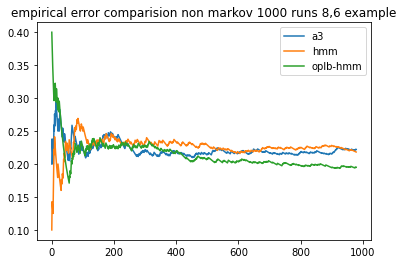

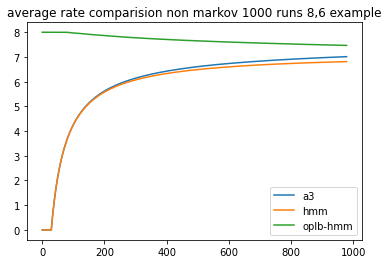

In [26]:
stat = 20
plt.plot(error_plot_a3[stat:1000])
plt.plot(error_plot_hmm[stat:1000])
plt.plot(error_plot_oplb[stat:1000])
plt.title('empirical error comparision non markov 1000 runs 8,6 example')
plt.legend(['a3','hmm','oplb-hmm'])
plt.show()
stat = 20
plt.plot(rate_plot_a3[stat:1000])
plt.plot(rate_plot_hmm[stat:1000])
plt.plot(rate_plot_oplb[stat:1000])
plt.title('average rate comparision non markov 1000 runs 8,6 example')
plt.legend(['a3','hmm','oplb-hmm'])
plt.show()

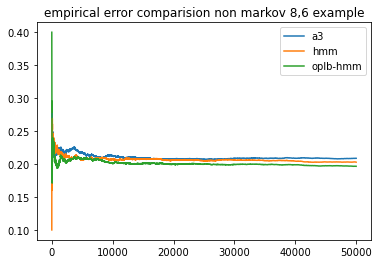

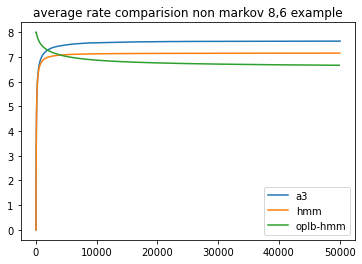

In [27]:
stat = 20
plt.plot(error_plot_a3[stat:])
plt.plot(error_plot_hmm[stat:])
plt.plot(error_plot_oplb[stat:])
plt.title('empirical error comparision non markov 8,6 example')
plt.legend(['a3','hmm','oplb-hmm'])
plt.show()
stat = 20
plt.plot(rate_plot_a3[stat:])
plt.plot(rate_plot_hmm[stat:])
plt.plot(rate_plot_oplb[stat:])
plt.title('average rate comparision non markov 8,6 example')
plt.legend(['a3','hmm','oplb-hmm'])
plt.show()

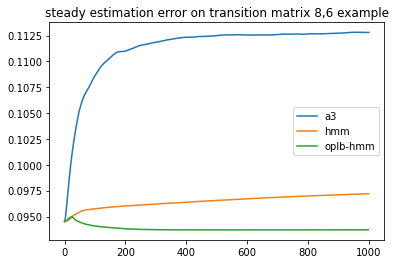

In [25]:
plt.plot(err_a3)
plt.plot(err_hmm)
plt.plot(err_oplb)
plt.title('steady estimation error on transition matrix 8,6 example')
plt.legend(['a3','hmm','oplb-hmm'])
plt.show()

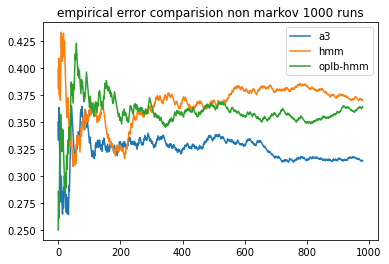

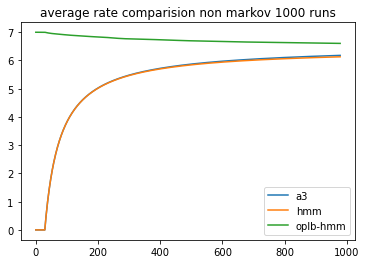

In [11]:
stat = 20
plt.plot(error_plot_a3[stat:1000])
plt.plot(error_plot_hmm[stat:1000])
plt.plot(error_plot_oplb[stat:1000])
plt.title('empirical error comparision non markov 1000 runs 5,4 example')
plt.legend(['a3','hmm','oplb-hmm'])
plt.show()
stat = 20
plt.plot(rate_plot_a3[stat:1000])
plt.plot(rate_plot_hmm[stat:1000])
plt.plot(rate_plot_oplb[stat:1000])
plt.title('average rate comparision non markov 1000 runs 5,4 example')
plt.legend(['a3','hmm','oplb-hmm'])
plt.show()

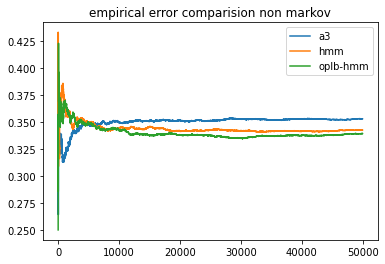

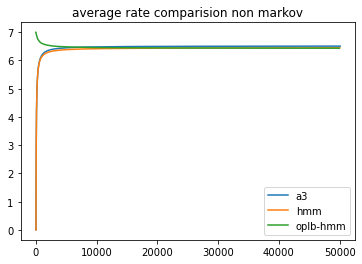

In [12]:
stat = 20
plt.plot(error_plot_a3[stat:])
plt.plot(error_plot_hmm[stat:])
plt.plot(error_plot_oplb[stat:])
plt.title('empirical error comparision non markov 5,4 example')
plt.legend(['a3','hmm','oplb-hmm'])
plt.show()
stat = 20
plt.plot(rate_plot_a3[stat:])
plt.plot(rate_plot_hmm[stat:])
plt.plot(rate_plot_oplb[stat:])
plt.title('average rate comparision non markov 5,4 example')
plt.legend(['a3','hmm','oplb-hmm'])
plt.show()

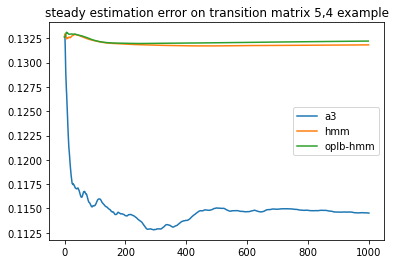

In [31]:
plt.plot(err_a3)
plt.plot(err_hmm)
plt.plot(err_oplb)
plt.title('steady estimation error on transition matrix 5,4 example')
plt.legend(['a3','hmm','oplb-hmm'])
plt.show() 

In [8]:
# example 2
en = 5
ch = 4
P = np.array([.3,.1,.2,.4])
E = np.array([[.4,.6,.4,.3],[.3,.4,.4,.3],[.3,.2,.1,.4],[.1,.35,.3,.4],[.2,.4,.1,.3]])
R = np.array([7.,5.5,4.,6.,5.])
tol = .35
print(P)
print(E)
print(R)
print(tol)
# finding safe x0
ub = E.transpose();tol_arr = [tol]*ch
ltemp = linprog(c=np.zeros(en),A_ub = ub,b_ub=tol_arr,A_eq = np.ones((1,en)),b_eq = [1.0],method='revised simplex',options={'tol': 1.0e-3})
x0 = np.transpose(row_normalize([ltemp.x+(0.05)])) # noise to safe to avoid singular matrices, 1.0e-2 is working
norm_x0 = linalg.norm(x0)
e0 = x0/norm_x0 # safe vector
e0_trans = e0.transpose()
en0 = sample(x0.transpose()[0])
b0 = bernoulli(E[en0][sample(P)])
# yt = (E[en0]*(1-b0))+((1-E[en0])*b0)
# yt = row_normalize([np.exp(yt)]).transpose()
# c0 = dot(x0,np.matmul(E,yt)) # safe cost
print(x0.flatten(),np.max(np.matmul(x0.transpose(),E)),dot(x0.transpose(),R))
# parameters
reg = 0.1 # lambda > 0, regualarization param
conf = 0.1 # delta >= 0, <= 1, confidence prob -> with 1-del prob tolerance holds
alfa_c = 1.0 # >= 1, ellipse radii
Sa = 1.;La = 1.;Ra = 1. # assumption parameters
# x = [np.transpose(row_normalize([np.ones(en)]))]
x = [x0]
r = [dot(x[-1].transpose(),R)];c = [0]
b = []; enc = [];chnl = []
rate = []
def qclp_solver(A,C,x0,R,en,tol):
    A = cvxopt.matrix(A)
    C = cvxopt.matrix(C)
    x0 = cvxopt.matrix(x0)
    R = cvxopt.matrix(R)
    def F(x = None, z = None):
        if x is None:  return (1, x0)
        if max(x) > 1.0 or min(x) < 0.0: return (None,None)
        f = (A*x) +  (x.trans()*C*x) - cvxopt.matrix([tol])
        df = A + (2.0*C*x).trans()
        if z is None: return (f,df)
        h = 2*z[0]*C
        return (f,df,h)
    sol = cvxopt.solvers.cpl(-1.0*R, F, None, None, None, cvxopt.matrix([1.0]*en).trans(), cvxopt.matrix([1.0]),kktsolver='ldl', options={'show_progress':False,'kktreg':1e-5})['x']
    return np.array(sol), ((A*sol)+(sol.trans()*C*sol))[0]
# 'kktreg':1e-9, kktsolver='ldl','maxiters':30
# algo
iop = np.identity(en) - (np.matmul(x0,x0.transpose())/pow(norm_x0,2.0))
sigopt = reg*iop; uopt = 0.0
for t in range(1,2000):
    enc.append(sample(x[-1].transpose()[0]))
    chnl.append(sample(P))
    b.append(bernoulli(E[enc[-1]][chnl[-1]]))
    # yt = (E[enc[-1]]*(1-b[-1]))+((1-E[enc[-1]])*b[-1])
    # yt = row_normalize([np.exp(yt)]).transpose()
    r.append(dot(x[-1],R))
    c.append(1.0 - b[-1])  # c.append(dot(x[-1],np.matmul(E,yt)))
    copt = c[-1] - (dot(x[-1],e0)/norm_x0)*c[0]
    xopt = x[-1] - (dot(x[-1],e0)*e0)
    sigopt += np.matmul(xopt,xopt.transpose())
    uopt += (copt*xopt)
    muopt = np.matmul(linalg.pinv(sigopt),uopt) # (inverse is blowing up, singular matrices) so did pseudo(SVD)
    A = (((c[0]/norm_x0)*e0_trans)+muopt.transpose()+(dot(e0,muopt)*e0_trans))
    betat = Ra*math.sqrt(en*math.log10((1+(t-1)*La*La/reg)/conf))+math.sqrt(reg)*Sa # used log10
    d = -2*alfa_c*betat
    l = alfa_c*betat*(1+pow(dot(e0,e0),2.0))
    C = ((l*np.identity(en)) + (d*np.matmul(e0,e0_trans)))
    sol = qclp_solver(A,C,x0,R,en,tol)
    x.append(sol[0])
    rate.append(dot(x[-1].transpose(),R))
    print(t,rate[-1],sol[1])
# print(copt)
# print(xopt)
# print(sigopt)
# print(uopt)
# print(muopt)
# print(A,betat)
error_plot_oplb_cvx = 1.0 - np.copy(b)
for i in range(1,len(error_plot_oplb_cvx)):
    error_plot_oplb_cvx[i] += (error_plot_oplb_cvx[i-1]*(i-1))
    error_plot_oplb_cvx[i] =error_plot_oplb_cvx[i]/i
rate_plot_oplb_cvx = np.copy(rate)
for i in range(1,len(rate_plot_oplb_cvx)):
    rate_plot_oplb_cvx[i] += (rate_plot_oplb_cvx[i-1]*(i-1))
    rate_plot_oplb_cvx[i] =rate_plot_oplb_cvx[i]/i

[0.3 0.1 0.2 0.4]
[[0.4  0.6  0.4  0.3 ]
 [0.3  0.4  0.4  0.3 ]
 [0.3  0.2  0.1  0.4 ]
 [0.1  0.35 0.3  0.4 ]
 [0.2  0.4  0.1  0.3 ]]
[7.  5.5 4.  6.  5. ]
0.35
[0.24 0.24 0.44 0.04 0.04] 0.35800000000000004 5.2
1 5.811296346861691 0.3500000371517409
2 5.721192376955708 0.3500000096504788
3 5.570633077425686 0.35000004069960067
4 5.5779792706857885 0.3500000501001803
5 5.584825714706126 0.350000059725333
6 5.533659461318915 0.35000000084989624
7 5.540136506147322 0.35000000083402955
8 5.54624976800554 0.3500000008246913
9 5.5143329693861025 0.3500000013276139
10 5.519658667731967 0.35000000126857356
11 5.524785530155323 0.35000000121678576
12 5.529704826560119 0.35000000117281577
13 5.534412151586914 0.35000000113675256
14 5.538906420812733 0.35000000110840945
15 5.5431891326236205 0.35000000108744667
16 5.547263792345152 0.3500000010734451
17 5.524911791226424 0.35000000140214615
18 5.528641389817498 0.3500000013610586
19 5.532240592964731 0.3500000013258974
20 5.514399329160803 0.350

In [9]:
# example 2
en = 5
ch = 4
P = np.array([.3,.1,.2,.4])
E = np.array([[.4,.6,.4,.3],[.3,.4,.4,.3],[.3,.2,.1,.4],[.1,.35,.3,.4],[.2,.4,.1,.3]])
R = np.array([7.,5.5,4.,6.,5.])
tol = .35
print(P)
print(E)
print(R)
print(tol)
# finding safe x0
ub = E.transpose();tol_arr = [tol]*ch
ltemp = linprog(c=np.zeros(en),A_ub = ub,b_ub=tol_arr,A_eq = np.ones((1,en)),b_eq = [1.0],method='revised simplex',options={'tol': 1.0e-3})
x0 = np.transpose(row_normalize([ltemp.x+(0.05)])) # noise to safe to avoid singular matrices, 1.0e-2 is working
norm_x0 = linalg.norm(x0)
e0 = x0/norm_x0 # safe vector
e0_trans = e0.transpose()
en0 = sample(x0.transpose()[0])
b0 = bernoulli(E[en0][sample(P)])
# yt = (E[en0]*(1-b0))+((1-E[en0])*b0)
# yt = row_normalize([np.exp(yt)]).transpose()
# c0 = dot(x0,np.matmul(E,yt)) # safe cost
print(x0.flatten(),np.max(np.matmul(x0.transpose(),E)),dot(x0.transpose(),R))
# parameters
reg = 0.1 # lambda > 0, regualarization param
conf = 0.01 # delta >= 0, <= 1, confidence prob -> with 1-del prob tolerance holds
alfa_c = 0.01 # >= 1, ellipse radii
Sa = 1.;La = 1.;Ra = 1. # assumption parameters
# x = [np.transpose(row_normalize([np.ones(en)]))]
x = [x0]
r = [dot(x[-1].transpose(),R)];c = [0.0]
b = []; enc = [];chnl = []
rate = []
alfa_c1 = alfa_c
alfa_c2 = alfa_c
def qclp_solver(A,C,x0,R,en,tol):
    A = cvxopt.matrix(A)
    C = cvxopt.matrix(C)
    x0 = cvxopt.matrix(x0)
    R = cvxopt.matrix(R)
    def F(x = None, z = None):
        if x is None:  return (1, x0)
        if max(x) > 1.0 or min(x) < 0.0: return (None,None)
        f = (A*x) +  (x.trans()*C*x) - cvxopt.matrix([tol])
        df = A + (2.0*C*x).trans()
        if z is None: return (f,df)
        h = 2*z[0]*C
        return (f,df,h)
    sol = cvxopt.solvers.cpl(-1.0*R, F, None, None, None, cvxopt.matrix([1.0]*en).trans(), cvxopt.matrix([1.0]),kktsolver='ldl', options={'show_progress':False,'kktreg':1e-5})['x']
    return np.array(sol), ((A*sol)+(sol.trans()*C*sol))[0]
# 'kktreg':1e-9, kktsolver='ldl','maxiters':30
# algo
iop = np.identity(en) - (np.matmul(x0,x0.transpose())/pow(norm_x0,2.0))
sigopt = reg*iop; uopt = 0.0
tolx = tol
step = 50
for t in range(1,2000):
    enc.append(sample(x[-1].transpose()[0]))
    chnl.append(sample(P))
    b.append(bernoulli(E[enc[-1]][chnl[-1]]))
    # yt = (E[enc[-1]]*(1-b[-1]))+((1-E[enc[-1]])*b[-1])
    # yt = row_normalize([np.exp(yt)]).transpose()
    r.append(dot(x[-1],R))
    c.append(1.0 - b[-1])  # c.append(dot(x[-1],np.matmul(E,yt)))
    copt = c[-1] - (dot(x[-1],e0)/norm_x0)*c[0]
    xopt = x[-1] - (dot(x[-1],e0)*e0)
    sigopt += np.matmul(xopt,xopt.transpose())
    uopt += (copt*xopt)
    muopt = np.matmul(linalg.pinv(sigopt),uopt) # (inverse is blowing up, singular matrices) so did pseudo(SVD)
    A = (((c[0]/norm_x0)*e0_trans)+muopt.transpose()+(dot(e0,muopt)*e0_trans))
    betat = Ra*math.sqrt(en*math.log((1+(t-1)*La*La/reg)/conf))+math.sqrt(reg)*Sa # used log10
    d = -2*alfa_c1*betat
    l = alfa_c2*betat*(1+pow(dot(e0,e0),2.0))
    C = ((l*np.identity(en)) + (d*np.matmul(e0,e0_trans)))
    if t%step == 0:
        tolx += (tol-np.mean(c))
    sol = qclp_solver(A,C,x0,R,en,tolx)
    x.append(sol[0])
    rate.append(dot(x[-1].transpose(),R))
    print(t,rate[-1],sol[1],tolx)
# print(copt)
# print(xopt)
# print(sigopt)
# print(uopt)
# print(muopt)
# print(A,betat)
error_plot_oplb_cvxa = 1.0 - np.copy(b)
for i in range(1,len(error_plot_oplb_cvxa)):
    error_plot_oplb_cvxa[i] += (error_plot_oplb_cvxa[i-1]*(i-1))
    error_plot_oplb_cvxa[i] =error_plot_oplb_cvxa[i]/i
rate_plot_oplb_cvxa = np.copy(rate)
for i in range(1,len(rate_plot_oplb_cvxa)):
    rate_plot_oplb_cvxa[i] += (rate_plot_oplb_cvxa[i-1]*(i-1))
    rate_plot_oplb_cvxa[i] =rate_plot_oplb_cvxa[i]/i

[0.3 0.1 0.2 0.4]
[[0.4  0.6  0.4  0.3 ]
 [0.3  0.4  0.4  0.3 ]
 [0.3  0.2  0.1  0.4 ]
 [0.1  0.35 0.3  0.4 ]
 [0.2  0.4  0.1  0.3 ]]
[7.  5.5 4.  6.  5. ]
0.35
[0.24 0.24 0.44 0.04 0.04] 0.35800000000000004 5.2
1 6.038461529926494 0.013195458926009367 0.35
2 5.712034563390568 0.3500000621690977 0.35
3 5.814194310052691 0.35000002708023925 0.35
4 5.95641224944028 0.35000000170415174 0.35
5 6.03866646482593 0.30335976121115743 0.35
6 6.0393834036335825 0.24022069970414706 0.35
7 6.041280600228343 0.20035330416415226 0.35
8 6.045796715005257 0.17331100602044458 0.35
9 6.054143702598301 0.15417009710865687 0.35
10 6.067431985008334 0.1403235164409899 0.35
11 5.8249156585520145 0.16746206983740536 0.35
12 5.884604444828874 0.21723891696088682 0.35
13 5.866220187931173 0.1016860995609411 0.35
14 5.286861368322404 0.004396744750413322 0.35
15 5.276169163726986 0.009788012567743781 0.35
16 5.276306631336251 0.009756694152312109 0.35
17 5.277864520250905 0.019487464419951868 0.35
18 5.27764843

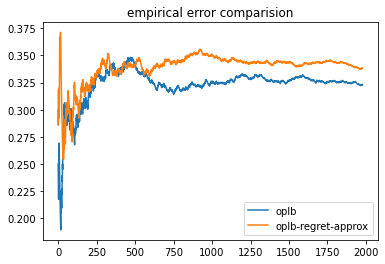

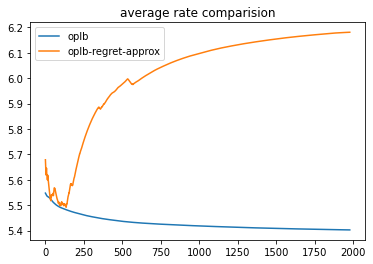

In [10]:
stat = 20
plt.plot(error_plot_oplb_cvx[stat:])
plt.plot(error_plot_oplb_cvxa[stat:])
plt.title('empirical error comparision')
plt.legend(['oplb','oplb-regret-approx'])
plt.show()
stat = 20
plt.plot(rate_plot_oplb_cvx[stat:])
plt.plot(rate_plot_oplb_cvxa[stat:])
plt.title('average rate comparision')
plt.legend(['oplb','oplb-regret-approx'])
plt.show()

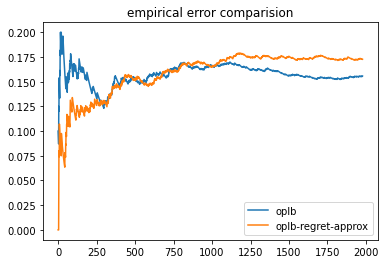

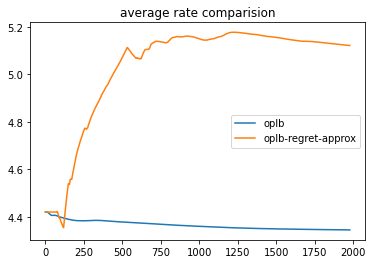

In [7]:
stat = 20
plt.plot(error_plot_oplb_cvx[stat:])
plt.plot(error_plot_oplb_cvxa[stat:])
plt.title('empirical error comparision')
plt.legend(['oplb','oplb-regret-approx'])
plt.show()
stat = 20
plt.plot(rate_plot_oplb_cvx[stat:])
plt.plot(rate_plot_oplb_cvxa[stat:])
plt.title('average rate comparision')
plt.legend(['oplb','oplb-regret-approx'])
plt.show()